# Homework 1

## Part 1: Mortality Prediction in the ICU

The dataset you will use for this homework assignment can be found at the following link: https://drive.google.com/drive/folders/1n-fmx1jS_IWEsUj3EzlZ1qZ0hxqtSnZF?usp=sharing

Please make sure to copy the files to your own google drive folder and substitute the path to that file below to load the dataset.

In [30]:
from google.colab import drive

# Will ask for authentication, click allow
drive.mount("/content/drive")

# Enter the correct path here
#------YOUR CODE HERE--------
path_to_data_folder = "/content/drive/My Drive/953/hst_953_2022_data"
#------YOUR CODE ENDS--------


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the GOSSIS dataset into a pandas dataframe
df = pd.read_csv(os.path.join(path_to_data_folder, "gossis.csv"))

(a)

In [32]:
#list(df.columns)

In [33]:
#------YOUR CODE HERE--------
# Enter the features corresponding to each category as a list below
# category (a)
# relevant features, all the features other than the ones listed below
relevant_features = list(df.drop(columns=['encounter_id', 'patient_id', 'hospital_id', "icu_id",  
                       "apache_2_diagnosis", "apache_2_bodysystem", 
                       "apache_3j_bodysystem", "apache_3j_diagnosis",
                       "apache_4a_hospital_death_prob", "apache_4a_icu_death_prob", 
                              "h1_blood_culture", "h1_urine_culture",
                              "h1_sputum_culture", "d1_medication_name", 
                              "d1_medication_dosage", "d1_medication_name_complete",
                              "h1_serum_immunoglobulins_iga", "h1_serum_immunoglobulins_igg",
                              "h1_serum_immunoglobulins_igm", "h1_anca",
                              "h1_serum_complement_total_C3", "h1_serum_complement_total_C4"]).columns)

# category (b)
irrelevant_features = ['encounter_id', 'patient_id', 'hospital_id', "icu_id",  
                       "apache_2_diagnosis", "apache_2_bodysystem", 
                       "apache_3j_bodysystem", "apache_3j_diagnosis"]

# category (c)
potentially_leaky_features = ["apache_4a_hospital_death_prob", "apache_4a_icu_death_prob", 
                              "h1_blood_culture", "h1_urine_culture",
                              "h1_sputum_culture", "d1_medication_name", 
                              "d1_medication_dosage", "d1_medication_name_complete",
                              "h1_serum_immunoglobulins_iga", "h1_serum_immunoglobulins_igg",
                              "h1_serum_immunoglobulins_igm", "h1_anca",
                              "h1_serum_complement_total_C3", "h1_serum_complement_total_C4"]
#------YOUR CODE ENDS--------

# Features to drop: categories (b) and (c)
features_to_drop = irrelevant_features + potentially_leaky_features

# Ground truth labels
label = "hospital_death"

(b)

In [34]:
# Define the dataset and the target variable
X = df.drop(columns=features_to_drop+[label])
y = df[[label]]
# Populate the following list with the names of the binary features
# that you didn't drop from the dataset
#------YOUR CODE HERE--------
remaining_binary_features = ["elective_surgery", "readmission_status", 
                             "apache_post_operative", "arf_apache",
                             "gcs_unable_apache", "intubated_apache",
                             "ventilated_apache", 
                             "aids", "cirrhosis", "diabetes_mellitus",
                             "hepatic_failure", "immunosuppression",
                             "leukemia", "lymphoma", "solid_tumor_with_metastasis"]
#------YOUR CODE ENDS--------

# Convert binary features into strings
# (to apply a specific preprocessing pipeline to those features later)
for c in remaining_binary_features:
    X[c] = X[c].fillna(-1)
    X[c] = X[c].astype(int)
    X[c] = X[c].astype(str)
    X[c] = X[c].replace("-1", np.nan)

In [35]:
sum(X["icu_type"] == np.nan)

0

In [36]:
# Preprocessing pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

#------YOUR CODE HERE--------
# Each of the below transformers should be either a preprocessing step
# (i.e. a scaler/encoder/imputer) or a pipeline (chain) of preprocessing
# steps

# For numerical features
numeric_transformer = Pipeline(steps=[
       ("encoder", StandardScaler()),
       ("imputer", SimpleImputer(strategy="mean", missing_values=np.nan)),
 ])


# For categorical features
categorical_transformer = Pipeline(steps=[
       ("encoder", OneHotEncoder())#,
       #("imputer", SimpleImputer(strategy="most_frequent", missing_values=np.nan)),
 ])

#numeric_transformer = StandardScaler()
#categorical_transformer = OneHotEncoder()

#------YOUR CODE ENDS--------

preprocessing = ColumnTransformer(
    transformers=[
        (
            "num",
            numeric_transformer,
            selector(dtype_exclude=["category", object, "string"]),
        ),
        (
            "cat",
            categorical_transformer,
            selector(dtype_include=["category", object, "string"]),
        ),
    ]
)

preprocessing_pipeline = Pipeline(
    steps=[("preprocessing", preprocessing)]
)

In [37]:
# Split the dataset into an 80%/20% train-test split
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [38]:
# Train the preprocessing pipeline on the train set and apply it on the test set
X_train = preprocessing_pipeline.fit_transform(X_train_raw)  # fit on train set
# extract new feature names
feature_names = list(preprocessing_pipeline[0].transformers_[0][2]) + list(preprocessing_pipeline[0].transformers_[1][1].get_feature_names_out())
#feature_names = list(preprocessing_pipeline[0].transformers_[0][2]) + list(preprocessing_pipeline[0].transformers_[1][1][0].get_feature_names_out())
X_train = pd.DataFrame(X_train, columns=feature_names)  # to dataframe type
# apply preprocessing pipeline to test set
X_test = pd.DataFrame(preprocessing_pipeline.transform(X_test_raw), columns=feature_names)

In [39]:
#list(preprocessing_pipeline[0].transformers_[1][1][0].get_feature_names_out())

(c)

In [40]:
from sklearn.linear_model import LogisticRegression

# Create and fit a logistic regression model
#------YOUR CODE HERE--------
logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(X_train, y_train.values.ravel())
#------YOUR CODE ENDS--------

LogisticRegression(max_iter=1000)

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import defaultdict

#------YOUR CODE HERE--------
# Fill out the following function to compute and return the different
# performance metrics of the input model. This is to avoid copying
# the same code to compute the metrics for each model
def evaluate_model(model, X_train, y_train, X_test, y_test, sample_weight=None):
    #model.fit(X_train, y_train)
    y_pred_tr = model.predict(X_train)
    Accuracy_tr = accuracy_score(y_train, y_pred_tr)
    # Precision Score = TP / (FP + TP)
    Precision_tr = precision_score(y_train, y_pred_tr, average='macro')
    # Recall Score = TP / (FN + TP)
    Recall_tr = recall_score(y_train, y_pred_tr, average='macro')
    F1score_tr = f1_score(y_train, y_pred_tr, average='macro')
    AUCscore_tr = roc_auc_score(y_train, y_pred_tr)

    y_pred = model.predict(X_test)
    #accuracy = model.score(X_test, y_test)
    Accuracy = accuracy_score(y_test, y_pred)
    # Precision Score = TP / (FP + TP)
    Precision = precision_score(y_test, y_pred, average='macro')
    # Recall Score = TP / (FN + TP)
    Recall = recall_score(y_test, y_pred, average='macro')
    F1score = f1_score(y_test, y_pred, average='macro')
    AUCscore = roc_auc_score(y_test, y_pred)
    #fpr, tpr, thresholds = metrics.roc_curve(y_test, estimator.predict_proba(X_test)[:,1]) 
    # https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
    #pass
    # Sample DataFrame
    d = {'Train': [Accuracy_tr, Precision_tr, Recall_tr, F1score_tr, AUCscore_tr], 
         'Test': [Accuracy, Precision, Recall, F1score, AUCscore]}
    report = pd.DataFrame(data=d,  index=['Accuracy', 'Precision', 
                                                  'Recall', 'F1-score', 
                                                  'AUC score'])
    return report
#------YOUR CODE ENDS--------

In [42]:
# Use evaluate_model to compute the different performance metrics for your linear regression model
#------YOUR CODE HERE--------
report_lr = evaluate_model(logisticRegr, X_train, y_train, X_test, y_test)
report_lr
# print('Accuracy of logistic regression classifier on the test set: {:.4f}'.format(Accuracy))
# print('Precision of logistic regression classifier on the test set: {:.4f}'.format(Precision))
# print('Recall of logistic regression classifier on the test set: {:.4f}'.format(Recall))
# print('F1-score of logistic regression classifier on the test set: {:.4f}'.format(F1score))
# print('AUC score of logistic regression classifier on the test set: {:.4f}'.format(AUCscore))
#report_lr['Test']["AUC score"]

#------YOUR CODE ENDS--------

,Train,Test
Accuracy,0.927450,0.925367
Precision,0.812247,0.799006
Recall,0.639087,0.633143
F1-score,0.684988,0.676840
AUC score,0.639087,0.633143


(d)

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Create and fit a random forest
# Use random_state=42 for consistency
#------YOUR CODE HERE--------
RandonFst = RandomForestClassifier(random_state=42)
RandonFst.fit(X_train, y_train.values.ravel())
#------YOUR CODE ENDS--------

RandomForestClassifier(random_state=42)

In [44]:
# Use evaluate_model to compute the different performance metrics for your random forest
#------YOUR CODE HERE--------
report_rf = evaluate_model(RandonFst, X_train, y_train, X_test, y_test)
report_rf
#------YOUR CODE ENDS--------

,Train,Test
Accuracy,0.999973,0.928529
Precision,0.999985,0.853355
Recall,0.999842,0.619472
F1-score,0.999914,0.667566
AUC score,0.999842,0.619472


In [45]:
import xgboost

# Create and fit an xgboost model
# Use random_state=42 for consistency
#------YOUR CODE HERE--------
xgbRF = xgboost.XGBRFClassifier(random_state=42)
xgbRF.fit(X_train, y_train.values.ravel())
#------YOUR CODE ENDS--------


XGBRFClassifier(random_state=42)

In [46]:
# Use evaluate_model to compute the different performance metrics for your xgboost model
#------YOUR CODE HERE--------
report_xgb = evaluate_model(xgbRF, X_train, y_train, X_test, y_test)
report_xgb
#------YOUR CODE ENDS--------

,Train,Test
Accuracy,0.921289,0.922695
Precision,0.835541,0.860589
Recall,0.563945,0.569788
F1-score,0.591530,0.600895
AUC score,0.563945,0.569788


(e)

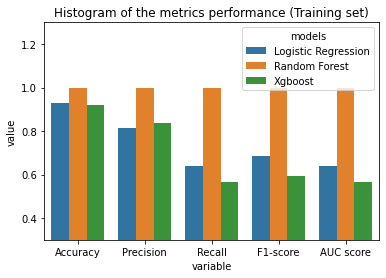

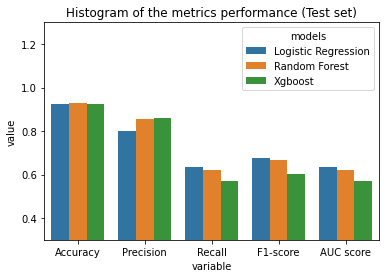

In [47]:
# Plot the performance metrics on a histogram
# You may use any python library of your choice
#------YOUR CODE HERE--------
import seaborn as sns
import matplotlib.pyplot as plt
plt.ylim(0.3, 1.3)
models = ["Logistic Regression", "Random Forest", "Xgboost"]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score']
train_hist = pd.concat([report_lr['Train'], report_rf['Train'], report_xgb['Train']],axis=1)
a=[e for model in zip(*[models]*5) for e in model]
d = train_hist.melt()
d['models'] = a
d['variable'] = metrics *3
plt.title("Histogram of the metrics performance (Training set)")
sns.barplot(y='value',x='variable',hue='models',data=d)
plt.show()


plt.ylim(0.3, 1.3)
models = ["Logistic Regression", "Random Forest", "Xgboost"]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score']
train_hist = pd.concat([report_lr['Test'], report_rf['Test'], report_xgb['Test']],axis=1)
a=[e for model in zip(*[models]*5) for e in model]
d = train_hist.melt()
d['models'] = a
d['variable'] = metrics *3
plt.title("Histogram of the metrics performance (Test set)")
sns.barplot(y='value',x='variable',hue='models',data=d)
plt.show()
#------YOUR CODE ENDS--------

(f) (answer this in your report)

(g)

In [48]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


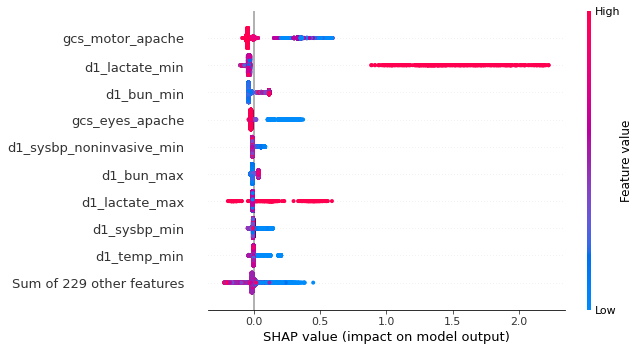

In [49]:
import shap

# Compute and plot the shapley values of the xgboost model on a beeswarm plot
#------YOUR CODE HERE--------
import shap
#explainer = shap.TreeExplainer(xgbRF)
#shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values, X_test, plot_type="bar", title = "")
#shap.summary_plot(shap_values, X_test)
explainer = shap.Explainer(xgbRF)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)
#------YOUR CODE ENDS--------

(h)

In [50]:
# Split the test set into cohorts in three different ways
# Remember to split both the input features and the ground truth labels!
#------YOUR CODE HERE--------
#X_test[X_test_raw['age']<65]
#X_test = pd.DataFrame(preprocessing_pipeline.transform(X_test_raw), columns=feature_names)
#X_test.iloc[X_test_raw[X_test_raw['age']<65].index]
#scaled_65 = np.unique(StandardScaler().fit_transform(X_test_raw[["age"]].fillna(np.nanmedian(X_test_raw[["age"]])))[X_test_raw["age"] == 65])[0]
#over_65 = (X_test["age"] >= scaled_65).values
#under_65 = np.invert(over_65)
# white and non-white patients
X_test_w =  X_test[X_test['ethnicity_Caucasian']==1]
X_test_nw =  X_test[X_test['ethnicity_Caucasian']==0]
y_test_w = y_test.iloc[X_test[X_test['ethnicity_Caucasian']==1].index]
y_test_nw = y_test.iloc[X_test[X_test['ethnicity_Caucasian']==0].index]

# male and female patients
X_test_F =  X_test[X_test['gender_F']==1]
X_test_M =  X_test[X_test['gender_M']==1]
y_test_F = y_test.iloc[X_test[X_test['gender_F']==1].index]
y_test_M = y_test.iloc[X_test[X_test['gender_M']==1].index]

# patients younger than 65 and patients 65 years old or older
X_test_L65 = X_test[(X_test_raw['age']<65).to_numpy()]
y_test_L65 = y_test[(X_test_raw['age']<65).to_numpy()]
X_test_U65 = X_test[(X_test_raw['age']>=65).to_numpy()]
y_test_U65 = y_test[(X_test_raw['age']>=65).to_numpy()]

#------YOUR CODE ENDS--------

(i) 

In [51]:
# Compute the performance metrics below
# You may use the evaluate_model function from before
#------YOUR CODE HERE--------
report_xgb_w = evaluate_model(xgbRF, X_train, y_train, X_test_w, y_test_w)
#report_xgb_w
report_xgb_nw = evaluate_model(xgbRF, X_train, y_train, X_test_nw, y_test_nw)
#report_xgb_nw
report_xgb_F = evaluate_model(xgbRF, X_train, y_train, X_test_F, y_test_F)
#report_xgb_F
report_xgb_M = evaluate_model(xgbRF, X_train, y_train, X_test_M, y_test_M)
#report_xgb_M
report_xgb_L65 = evaluate_model(xgbRF, X_train, y_train, X_test_L65, y_test_L65)
#report_xgb_L65
report_xgb_U65 = evaluate_model(xgbRF, X_train, y_train, X_test_U65, y_test_U65)
#report_xgb_U65


#------YOUR CODE ENDS--------

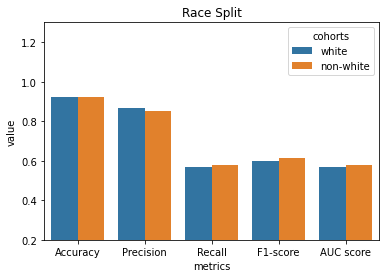

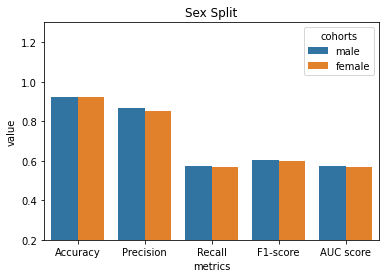

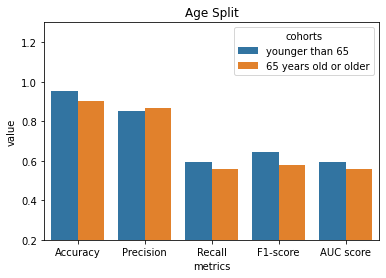

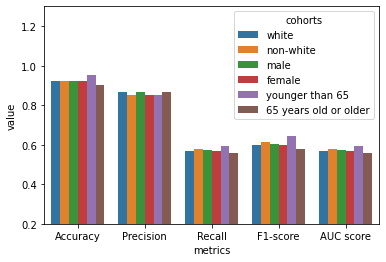

In [52]:
# Plot the performance metrics on a histogram for each of the cohort splits
#------YOUR CODE HERE--------
plt.ylim(0.2, 1.3)
cohorts = ["white", "non-white"]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score']
cohort_hist = pd.concat([report_xgb_w['Test'], report_xgb_nw['Test']],axis=1)
cohorts=[e for cohort in zip(*[cohorts]*5) for e in cohort]
cohort_hist = cohort_hist.melt()
cohort_hist['cohorts'] = cohorts
cohort_hist['metrics'] = metrics *2
cohort_hist
sns.barplot(y='value',x='metrics',hue='cohorts',data=cohort_hist)
plt.title("Race Split")
plt.show()

plt.ylim(0.2, 1.3)
cohorts = ["male", "female"]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score']
cohort_hist = pd.concat([report_xgb_M['Test'], 
                         report_xgb_F['Test']],axis=1)
cohorts=[e for cohort in zip(*[cohorts]*5) for e in cohort]
cohort_hist = cohort_hist.melt()
cohort_hist['cohorts'] = cohorts
cohort_hist['metrics'] = metrics *2
cohort_hist
sns.barplot(y='value',x='metrics',hue='cohorts',data=cohort_hist)
plt.title("Sex Split")
plt.show()

plt.ylim(0.2, 1.3)
cohorts = ["younger than 65", "65 years old or older"]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score']
cohort_hist = pd.concat([report_xgb_L65['Test'], report_xgb_U65['Test']],axis=1)
cohorts=[e for cohort in zip(*[cohorts]*5) for e in cohort]
cohort_hist = cohort_hist.melt()
cohort_hist['cohorts'] = cohorts
cohort_hist['metrics'] = metrics *2
cohort_hist
sns.barplot(y='value',x='metrics',hue='cohorts',data=cohort_hist)
plt.title("Age Split")
plt.show()


plt.ylim(0.2, 1.3)
cohorts = ["white", "non-white", "male", "female", "younger than 65", "65 years old or older"]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score']
cohort_hist = pd.concat([report_xgb_w['Test'], report_xgb_nw['Test'], report_xgb_M['Test'], 
                         report_xgb_F['Test'], report_xgb_L65['Test'], report_xgb_U65['Test']],axis=1)
cohorts=[e for cohort in zip(*[cohorts]*5) for e in cohort]
cohort_hist = cohort_hist.melt()
cohort_hist['cohorts'] = cohorts
cohort_hist['metrics'] = metrics *6
cohort_hist
sns.barplot(y='value',x='metrics',hue='cohorts',data=cohort_hist)

plt.show()
#------YOUR CODE ENDS--------


(j) Answer this question in your report

(k)

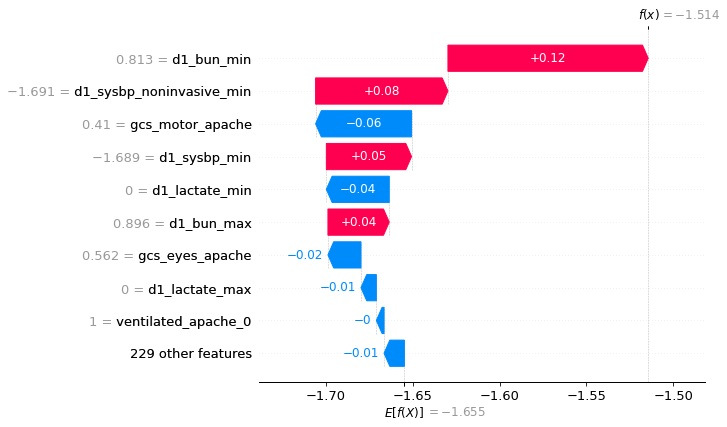

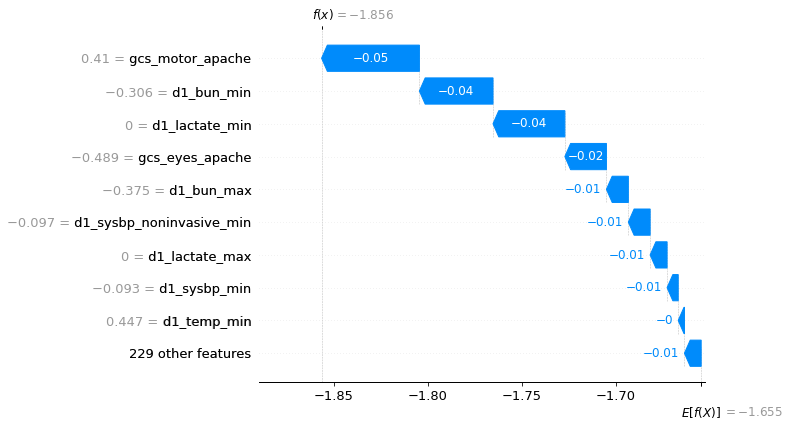

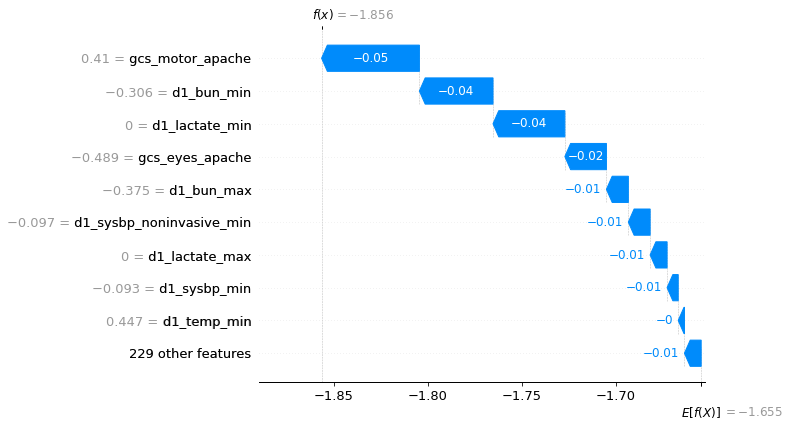

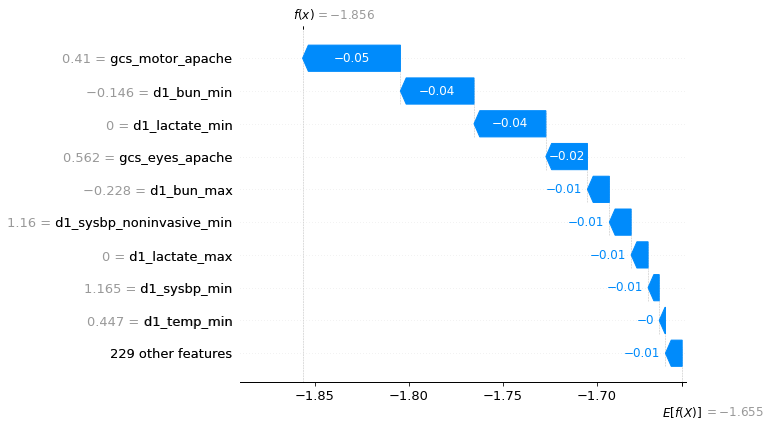

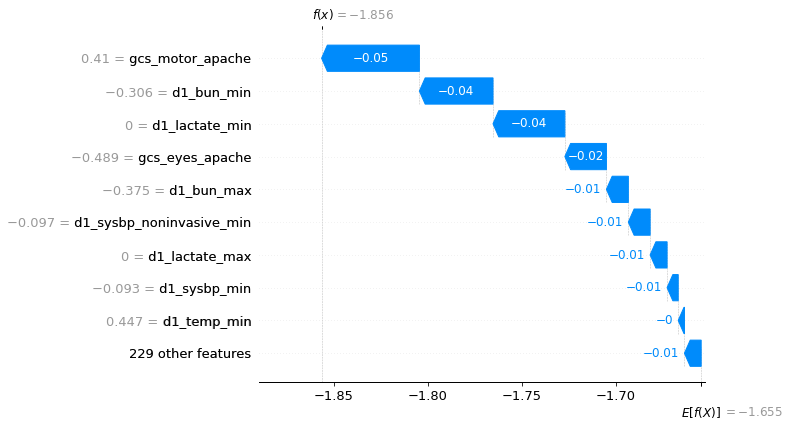

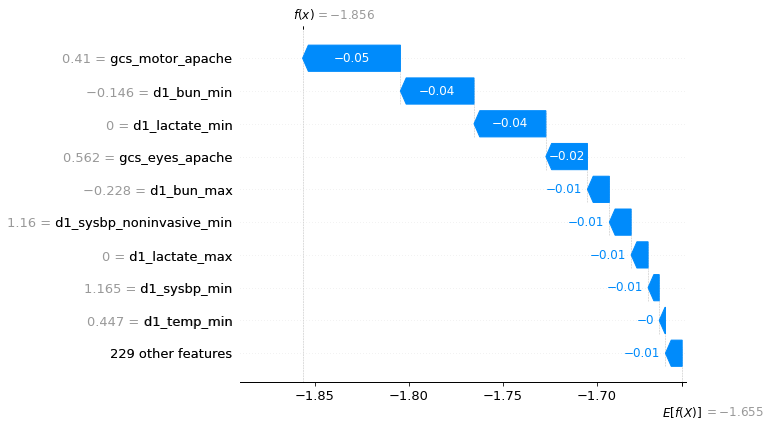

In [53]:
# Visualize the shapley values for the prediction of the first datapoint of each half
# of each split using a waterfall plot
#------YOUR CODE HERE--------
explainer = shap.Explainer(xgbRF)
shap_values_w = explainer(X_test_w)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values_w[0])

shap_values_nw = explainer(X_test_nw)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values_nw[0])

shap_values_M = explainer(X_test_M)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values_M[0])

shap_values_F = explainer(X_test_F)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values_F[0])

shap_values_L65 = explainer(X_test_L65)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values_L65[0])

shap_values_U65 = explainer(X_test_U65)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values_U65[0])
#------YOUR CODE ENDS--------

(l) Answer this question in your report

## Problem 2. Delving into Disparities 

(a) 

In [54]:
# Split the training set into cohorts the same way you split the test set before
#------YOUR CODE HERE--------
# white and non-white patients
X_train_w =  X_train[X_train['ethnicity_Caucasian']==1]
X_train_nw =  X_train[X_train['ethnicity_Caucasian']==0]
y_train_w = y_train.iloc[X_train[X_train['ethnicity_Caucasian']==1].index]
y_train_nw = y_train.iloc[X_train[X_train['ethnicity_Caucasian']==0].index]

# male and female patients
X_train_F =  X_train[X_train['gender_F']==1]
X_train_M =  X_train[X_train['gender_M']==1]
y_train_F = y_train.iloc[X_train[X_train['gender_F']==1].index]
y_train_M = y_train.iloc[X_train[X_train['gender_M']==1].index]

# patients younger than 65 and patients 65 years old or older
X_train_L65 = X_train[(X_train_raw['age']<65).to_numpy()]
y_train_L65 = y_train[(X_train_raw['age']<65).to_numpy()]
X_train_U65 = X_train[(X_train_raw['age']>=65).to_numpy()]
y_train_U65 = y_train[(X_train_raw['age']>=65).to_numpy()]
#------YOUR CODE ENDS--------

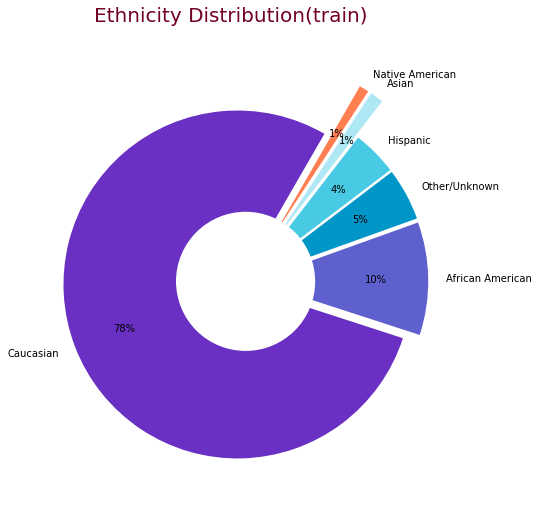

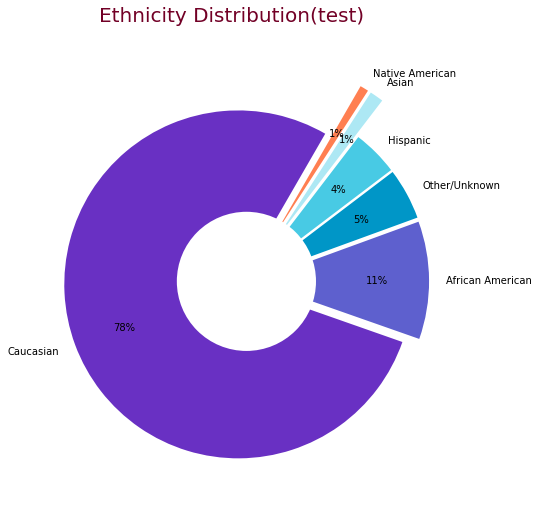

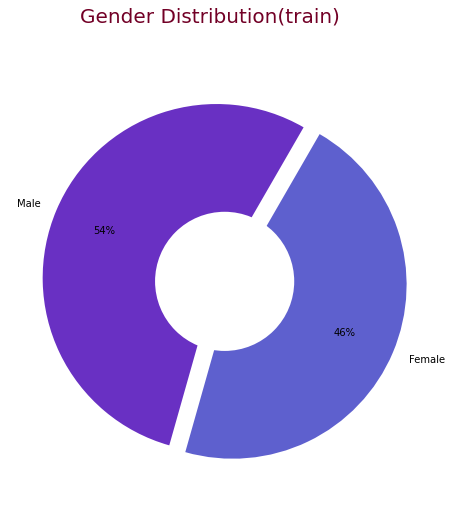

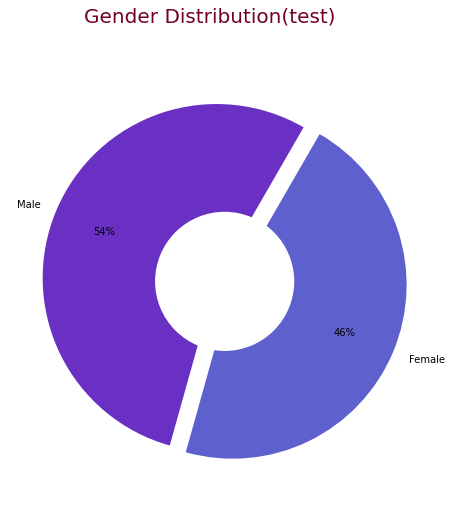

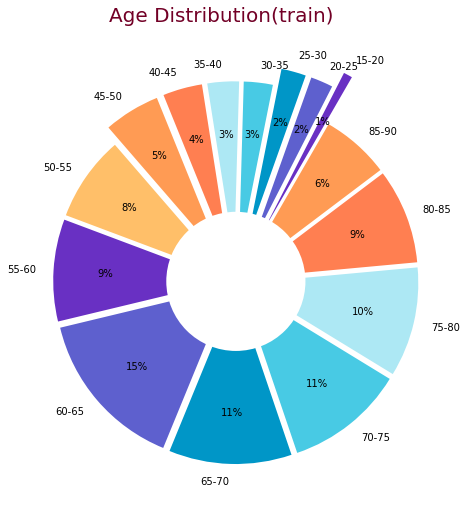

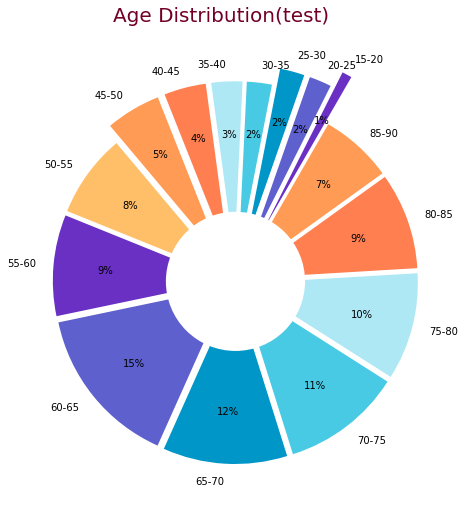

In [55]:
# Plot the distributions, each on a different pie chart
#------YOUR CODE HERE--------
#defining colour palette
#red = ["#4f000b","#720026","#ce4257","#ff7f51","#ff9b54"]
pie_c = ["#6930c3","#5e60ce","#0096c7","#48cae4","#ade8f4","#ff7f51","#ff9b54","#ffbf69"]
#pink = ["#aa4465","#dd2d4a","#f26a8d","#f49cbb","#ffcbf2","#e2afff","#ff86c8","#ffa3a5","#ffbf81","#e9b827","#f9e576"]

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Ethnicity Distribution(train)', size = 20, color = "#720026")
explode = (0.05, 0.05, 0.05, 0.05, 0.3, 0.3)
labels = ["Caucasian","African American","Other/Unknown","Hispanic","Asian","Native American"]
sizes = X_train_raw["ethnicity"].value_counts()
ax.pie(sizes, explode=explode, colors=pie_c, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.7)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()


fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Ethnicity Distribution(test)', size = 20, color = "#720026")
explode = (0.05, 0.05, 0.05, 0.05, 0.3, 0.3)
labels = ["Caucasian","African American","Other/Unknown","Hispanic","Asian","Native American"]
sizes = X_test_raw["ethnicity"].value_counts()
ax.pie(sizes, explode=explode, colors=pie_c, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.7)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Gender Distribution(train)', size = 20, color = "#720026")
explode = (0.05, 0.05)
labels = ["Male","Female"]
sizes = X_train_raw["gender"].value_counts()
ax.pie(sizes, explode=explode, colors=pie_c, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.7)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Gender Distribution(test)', size = 20, color = "#720026")
explode = (0.05, 0.05)
labels = ["Male","Female"]
sizes = X_test_raw["gender"].value_counts()
ax.pie(sizes, explode=explode, colors=pie_c, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.7)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()


import math
X_train_rawage = X_train_raw["age"]
X_train_rawage.fillna(X_train_raw["age"].mean(), inplace=True)
X_train_rawage=X_train_rawage.apply(lambda x: math.floor(x/5))
#print(X_train_rawage.min(),X_train_rawage.max())
age_labels = ["15-20","20-25", "25-30","30-35","35-40","40-45","45-50","50-55","55-60",
              "60-65", "65-70","70-75","75-80","80-85","85-90"]
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Age Distribution(train)', size = 20, color = "#720026")
explode = (0.35, 0.25, 0.25, 0.15, 0.15, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
sizes = X_train_rawage.value_counts().sort_index()
ax.pie(sizes, explode=explode, colors=pie_c, startangle=60, labels=age_labels,autopct='%1.0f%%', pctdistance=0.7)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

X_test_rawage = X_test_raw["age"]
X_test_rawage.fillna(X_test_raw["age"].mean(), inplace=True)
X_test_rawage=X_test_rawage.apply(lambda x: math.floor(x/5))
#print(X_train_rawage.min(),X_train_rawage.max())
age_labels = ["15-20","20-25", "25-30","30-35","35-40","40-45","45-50","50-55","55-60",
              "60-65", "65-70","70-75","75-80","80-85","85-90"]
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Age Distribution(test)', size = 20, color = "#720026")
explode = (0.35, 0.25, 0.25, 0.15, 0.15, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
sizes = X_test_rawage.value_counts().sort_index()
ax.pie(sizes, explode=explode, colors=pie_c, startangle=60, labels=age_labels,autopct='%1.0f%%', pctdistance=0.7)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()



#------YOUR CODE ENDS--------

(b) 

In [56]:
def drop_rows_criteria(df: pd.DataFrame,
                       outcome: pd.DataFrame,
                       pct_drop: float) -> pd.DataFrame:
    """
    Return two new versions of a dataset and the corresponding outcome
    without some rows based on a certain criteria
    (to change in the code of this function)

    Args:
        df (pd.DataFrame): initial dataset, pandas DataFrame format
        outcome (pd.DataFrame): outcome dataset, pandas DataFrame format
        pct_drop (float): percentage of chance to drop a value
            if a certain criteria is met

    Returns:
        pd.DataFrame: modified dataset
        pd.DataFrame: modified outcome
    
    Example:
        X_train_raw2, y_train2 = drop_rows_criteria(X_train_raw, y_train)
    """
    df2 = df.copy(deep=True).reset_index(drop=True)  # work on a copy of the dataframe
    outcome2 = outcome.copy(deep=True).reset_index(drop=True)
    indices_to_drop = []

    # Local rng for better reproducibility
    rng = np.random.default_rng(seed=42)
    for i in range(len(df2)):
        if df2.iat[i, df2.columns.get_loc("gender")] != "M":

            if rng.random() < pct_drop:  # pct_drop chance to drop this row
                indices_to_drop.append(i)
    df2.drop(indices_to_drop, axis=0, inplace=True)
    outcome2.drop(indices_to_drop, axis=0, inplace=True)
    return df2, outcome2

In [57]:
def evaluate_model2(model, X_train, y_train, X_test, y_test, X_test_M, y_test_M, X_test_F, y_test_F, sample_weight=None):
    
    # performance metrics on the modified training set
    y_pred_tr = model.predict(X_train)
    Accuracy_tr = accuracy_score(y_train, y_pred_tr)
    # Precision Score = TP / (FP + TP)
    Precision_tr = precision_score(y_train, y_pred_tr, average='macro')
    # Recall Score = TP / (FN + TP)
    Recall_tr = recall_score(y_train, y_pred_tr, average='macro')
    F1score_tr = f1_score(y_train, y_pred_tr, average='macro')
    AUCscore_tr = roc_auc_score(y_train, y_pred_tr)

    # performance metrics on the original test set
    y_pred = model.predict(X_test)
    #accuracy = model.score(X_test, y_test)
    Accuracy = accuracy_score(y_test, y_pred)
    # Precision Score = TP / (FP + TP)
    Precision = precision_score(y_test, y_pred, average='macro')
    # Recall Score = TP / (FN + TP)
    Recall = recall_score(y_test, y_pred, average='macro')
    F1score = f1_score(y_test, y_pred, average='macro')
    AUCscore = roc_auc_score(y_test, y_pred)
   
    # performance metrics on male patients from 1h
    y_pred = model.predict(X_test_M)
    #accuracy = model.score(X_test, y_test)
    Accuracy_test_M = accuracy_score(y_test_M, y_pred)
    # Precision Score = TP / (FP + TP)
    Precision_test_M = precision_score(y_test_M, y_pred, average='macro')
    # Recall Score = TP / (FN + TP)
    Recall_test_M = recall_score(y_test_M, y_pred, average='macro')
    F1score_test_M = f1_score(y_test_M, y_pred, average='macro')
    AUCscore_test_M = roc_auc_score(y_test_M, y_pred)


    # performance metrics on female patients from 1h
    y_pred = model.predict(X_test_F)
    #accuracy = model.score(X_test, y_test)
    Accuracy_test_F = accuracy_score(y_test_F, y_pred)
    # Precision Score = TP / (FP + TP)
    Precision_test_F = precision_score(y_test_F, y_pred, average='macro')
    # Recall Score = TP / (FN + TP)
    Recall_test_F = recall_score(y_test_F, y_pred, average='macro')
    F1score_test_F = f1_score(y_test_F, y_pred, average='macro')
    AUCscore_test_F = roc_auc_score(y_test_F, y_pred)

    # Sample DataFrame
    d = {'Modified Train': [Accuracy_tr, Precision_tr, Recall_tr, F1score_tr, AUCscore_tr], 
         'Test': [Accuracy, Precision, Recall, F1score, AUCscore],
         'Male': [Accuracy_test_M, Precision_test_M, Recall_test_M, F1score_test_M, AUCscore_test_M],
         'Female': [Accuracy_test_F, Precision_test_F, Recall_test_F, F1score_test_F, AUCscore_test_F]}
    report = pd.DataFrame(data=d,  index=['Accuracy', 'Precision', 
                                                  'Recall', 'F1-score', 
                                                  'AUC score'])
    return report

In [58]:
from tqdm import tqdm

report = {}
percentages = [0.2, 0.4, 0.6, 0.8]
for pct in tqdm(percentages):

    # Use drop_rows_criteria to drop pct% of the training data
    #------YOUR CODE HERE--------
    X_train_raw2, y_train2 = drop_rows_criteria(X_train_raw, y_train, pct)
    #------YOUR CODE ENDS--------
    
    # Create a fresh preprocessing pipeline
    preprocessing_pipeline2 = Pipeline(
        steps=[("preprocessing", preprocessing)]
    )


    # Fit the preprocessing pipeline to the new training set and store the
    # normalized version of that set in X_train2
    # (Question to think about: why should we do this?)
    #------YOUR CODE HERE--------
    X_train2 = preprocessing_pipeline.fit_transform(X_train_raw2)
    #------YOUR CODE ENDS--------

    # Extract new feature names
    features_names = list(preprocessing_pipeline2[0].transformers_[0][2]) + list(preprocessing_pipeline2[0].transformers_[1][1].get_feature_names_out())
    X_train2 = pd.DataFrame(X_train2, columns=features_names)  # to dataframe type
    X_test2 = pd.DataFrame(preprocessing_pipeline2.transform(X_test_raw), columns=features_names)

    # Split the new test data (X_test2) into male and female cohorts
    #------YOUR CODE HERE--------
    X_test2_F =  X_test2[X_test2['gender_F']==1]
    X_test2_M =  X_test2[X_test2['gender_M']==1]
    y_test2_F = y_test.iloc[X_test2[X_test2['gender_F']==1].index]
    y_test2_M = y_test.iloc[X_test2[X_test2['gender_M']==1].index]
    #------YOUR CODE ENDS--------

    # Create, fit, and evaluate your model
    # You may use evaluate_model from before
    #------YOUR CODE HERE--------
    xgbRF2 = xgboost.XGBRFClassifier(random_state=42)
    xgbRF2.fit(X_train2, y_train2.values.ravel())
    
    # performance metrics for the modified training set and for the original test set
    report = evaluate_model2(xgbRF2, X_train2, y_train2, X_test2, y_test, X_test2_M, y_test2_M, X_test2_F, y_test2_F)
    print("\n")
    print("Model trained on "+ str(pct*100) + "% missing females")
    display(report)

    #------YOUR CODE ENDS--------

  0%|          | 0/4 [00:00<?, ?it/s]



Model trained on 20.0% missing females


,Modified Train,Test,Male,Female
Accuracy,0.921705,0.922423,0.924134,0.920460
Precision,0.834023,0.853712,0.856275,0.850662
Recall,0.563868,0.569639,0.572351,0.566663
F1-score,0.591488,0.600498,0.604899,0.595599
AUC score,0.563868,0.569639,0.572351,0.566663


 25%|██▌       | 1/4 [00:34<01:42, 34.27s/it]



Model trained on 40.0% missing females


,Modified Train,Test,Male,Female
Accuracy,0.922344,0.922096,0.923730,0.920223
Precision,0.834639,0.851264,0.851582,0.850950
Recall,0.562106,0.567748,0.570514,0.564712
F1-score,0.589003,0.597596,0.602041,0.592633
AUC score,0.562106,0.567748,0.570514,0.564712


 50%|█████     | 2/4 [01:04<01:03, 31.93s/it]



Model trained on 60.0% missing females


,Modified Train,Test,Male,Female
Accuracy,0.922142,0.921714,0.923326,0.919867
Precision,0.841242,0.850232,0.852031,0.848117
Recall,0.557694,0.564972,0.567062,0.562696
F1-score,0.582313,0.593362,0.596875,0.589479
AUC score,0.557694,0.564972,0.567062,0.562696


 75%|███████▌  | 3/4 [01:34<00:31, 31.05s/it]



Model trained on 80.0% missing females


,Modified Train,Test,Male,Female
Accuracy,0.922676,0.922423,0.924336,0.920223
Precision,0.841503,0.850917,0.855970,0.844798
Recall,0.562015,0.570494,0.574077,0.566533
F1-score,0.589027,0.601702,0.607436,0.595268
AUC score,0.562015,0.570494,0.574077,0.566533


100%|██████████| 4/4 [01:58<00:00, 29.65s/it]
